Quick Notes:
* Is this the same as the chisquare test I was using - https://www.itl.nist.gov/div898/handbook/prc/section4/prc46.htm
* Traditional test for which ranked items are significantly greater - https://www.itl.nist.gov/div898/handbook/prc/section4/prc474.htm
* Beta-Binomial Tutorial - http://sl8r000.github.io/ab_testing_statistics/use_a_hierarchical_model/
* Multilevel Beta-Binomial - https://dsaber.com/2016/08/27/analyze-your-experiment-with-a-multilevel-logistic-regression-using-pymc3%E2%80%8B/
* Another Beta Binomial Tutorial - https://blog.dominodatalab.com/ab-testing-with-hierarchical-models-in-python/
* Pymc3 Beta Binomial Tutorial - https://docs.pymc.io/notebooks/GLM-hierarchical-binominal-model.html
* Another pymc3 beta binomial - https://dsaber.com/2016/08/27/analyze-your-experiment-with-a-multilevel-logistic-regression-using-pymc3%E2%80%8B/
* Note how the beta priors are created (the 5/2 thing). Test this in other regression with pymc3 project.
* Multi-level beta binomial question - https://stats.stackexchange.com/questions/230034/extending-a-hierarchical-beta-binomial-model-to-account-for-higher-level-groups
* Multilevel pymc3 - https://austinrochford.com/posts/2017-07-09-mrpymc3.html
* Partial Pooling - https://docs.pymc.io/notebooks/hierarchical_partial_pooling.html

In [1]:
%%bash
head ../processed_data/all_strikeouts_pa.out

aaroh101, Hank Aaron, 63, 598, 1970
aarot101, Tommie Aaron, 10, 66, 1970
abert101, Ted Abernathy, 7, 20, 1970
adaij101, Jerry Adair, 3, 33, 1970
ageet101, Tommie Agee, 156, 696, 1970
aguih101, Hank Aguirre, 2, 2, 1970
akerj102, Jack Aker, 6, 16, 1970
alcal101, Luis Alcaraz, 13, 127, 1970
alleb105, Bernie Allen, 21, 305, 1970
alled101, Dick Allen, 118, 533, 1970


In [2]:
import pandas as pd

DF = pd.read_csv('../processed_data/all_strikeouts_pa.out',
                 header=None,
                 names=['playerid', 'player_name', 'strikeouts', 'pa', 'year'])

In [3]:
DF.head()

,playerid,player_name,strikeouts,pa,year
0,aaroh101,Hank Aaron,63,598,1970
1,aarot101,Tommie Aaron,10,66,1970
2,abert101,Ted Abernathy,7,20,1970
3,adaij101,Jerry Adair,3,33,1970
4,ageet101,Tommie Agee,156,696,1970


In [4]:
import numpy as np

GROUPED_DF = (DF
              .groupby("year")
              .agg({'strikeouts': np.sum,
                    'pa': np.sum,
                   })
             )

GROUPED_DF["prop_strikeouts"] = GROUPED_DF["strikeouts"] / GROUPED_DF["pa"]

In [5]:
GROUPED_DF.describe()

,strikeouts,pa,prop_strikeouts
count,49.000000,49.000000,49.000000
mean,27411.285714,168774.551020,0.160451
std,6811.431867,19009.189224,0.025676
min,13237.000000,105892.000000,0.124924
25%,21716.000000,160033.000000,0.140129
50%,25425.000000,161922.000000,0.158785
75%,32189.000000,185553.000000,0.170653
max,41207.000000,190261.000000,0.222573


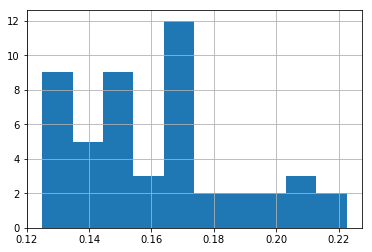

In [6]:
%matplotlib inline
GROUPED_DF["prop_strikeouts"].hist();

In [7]:
len(GROUPED_DF)

49

In [9]:
GROUPED_DF.head()

,strikeouts,pa,prop_strikeouts
year,,,
1970,22374,149332,0.149827
1971,20852,145958,0.142863
1972,20698,139815,0.148038
1973,20338,148637,0.136830
1974,19494,148855,0.130960


In [10]:
GROUPED_DF

,strikeouts,pa,prop_strikeouts
year,,,
1970,22374,149332,0.149827
1971,20852,145958,0.142863
1972,20698,139815,0.148038
1973,20338,148637,0.136830
1974,19494,148855,0.130960
1975,19280,148621,0.129726
1976,18745,147598,0.127000
1977,21722,161547,0.134462
1978,20058,159192,0.125999


In [11]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as tt

In [12]:
GROUPED_DF.shape

(49, 3)

In [13]:
with pm.Model() as bb_model:
 
    phi = pm.Uniform('phi', lower=0.0, upper=1.0)

    kappa_log = pm.Exponential('kappa_log', lam=1.5)
    kappa = pm.Deterministic('kappa', tt.exp(kappa_log))

    rates = pm.Beta('rates', alpha=phi*kappa, beta=(1.0-phi)*kappa, shape=len(GROUPED_DF))

 
    trials = np.array(GROUPED_DF["pa"])
    successes = np.array(GROUPED_DF["strikeouts"])
 
    obs = pm.Binomial('observed_values', trials, rates,
                      observed=successes)
    trace = pm.sample(2000, tune=1000, chains=2, cores=2, nuts_kwargs={'target_accept': .95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rates, kappa_log, phi]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:42<00:00, 141.15draws/s]


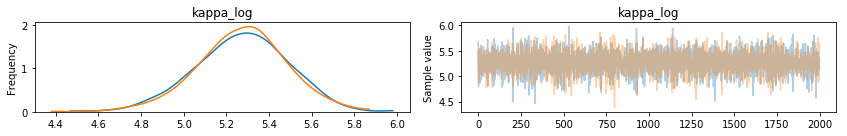

In [14]:
pm.traceplot(trace, varnames=['kappa_log']);

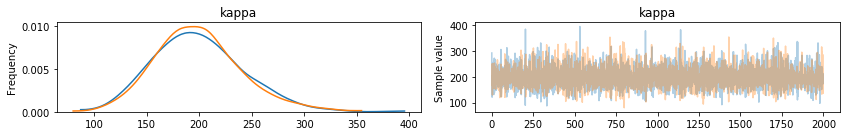

In [15]:
pm.traceplot(trace, varnames=['kappa']);

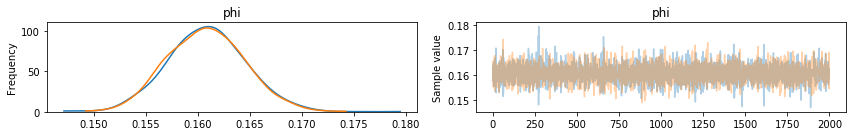

In [16]:
pm.traceplot(trace, varnames=['phi']);

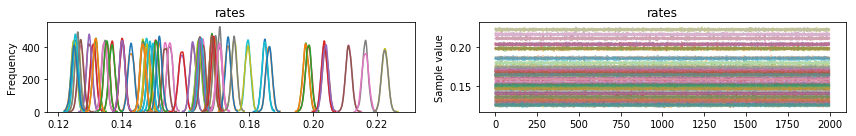

In [17]:
pm.traceplot(trace, varnames=['rates']);

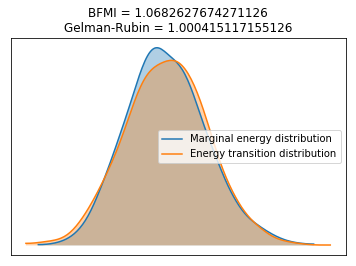

In [18]:
bfmi = pm.bfmi(trace)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(trace).values())
(pm.energyplot(trace, figsize=(6, 4)).set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

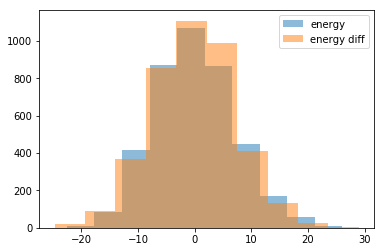

In [19]:
energy = trace['energy']
energy_diff = np.diff(energy)
plt.hist(energy - energy.mean(), label='energy', alpha=0.5)
plt.hist(energy_diff, label='energy diff', alpha=0.5)
plt.legend();

In [20]:
GROUPED_DF.head()

,strikeouts,pa,prop_strikeouts
year,,,
1970,22374,149332,0.149827
1971,20852,145958,0.142863
1972,20698,139815,0.148038
1973,20338,148637,0.136830
1974,19494,148855,0.130960


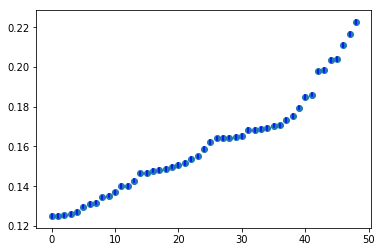

In [21]:
rate_means = trace['rates', 1000:].mean(axis=0)
rate_se = trace['rates', 1000:].std(axis=0)

mean_se = [(x, y, i) for i, x, y in zip(GROUPED_DF.index, rate_means, rate_se)]
sorted_means_se = sorted(mean_se, key=lambda x: x[0])
sorted_means = [x[0] for x in sorted_means_se]
sorted_se = [x[1] for x in sorted_means_se]

x = np.arange(len(sorted_means))

plt.plot(x, sorted_means, 'o');

for x_val, m, se in zip(x, sorted_means, sorted_se):
    plt.plot([x_val, x_val], [m-se, m+se], 'b-')

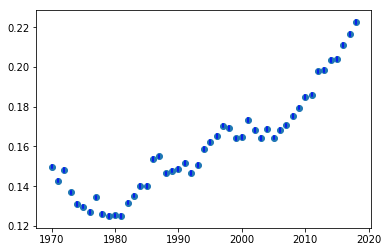

In [22]:
plt.plot(GROUPED_DF.index, rate_means, 'o');
for x_val, m, se in zip(GROUPED_DF.index, rate_means, rate_se):
    plt.plot([x_val, x_val], [m-se, m+se], 'b-')

In [23]:
sorted_means_se[:5]

[(0.1249820765535394, 0.0008238973206443722, 1979),
 (0.12506506488490912, 0.0009923066059299719, 1981),
 (0.12542282812494432, 0.0008059046311561689, 1980),
 (0.12605604984825827, 0.0008119045915262948, 1978),
 (0.12706977300786318, 0.0008777024824528197, 1976)]

In [24]:
sorted_means_se[-5:]

[(0.2035089636423048, 0.0009040547071524512, 2014),
 (0.20388652796345932, 0.00092543883685226, 2015),
 (0.21117310785744006, 0.0009592761649375174, 2016),
 (0.21637284104817386, 0.0009636338688238112, 2017),
 (0.22248726258065324, 0.0009928259568675018, 2018)]

In [25]:
GROUPED_DF.loc[[x[2] for x in sorted_means_se[-5:]], :]

,strikeouts,pa,prop_strikeouts
year,,,
2014,37441,183929,0.203562
2015,37446,183627,0.203924
2016,38996,184613,0.211231
2017,40104,185295,0.216433
2018,41207,185139,0.222573


In [26]:
GROUPED_DF.loc[[x[2] for x in sorted_means_se[:5]], :]

,strikeouts,pa,prop_strikeouts
year,,,
1979,20035,160378,0.124924
1981,13237,105892,0.125005
1980,20212,161210,0.125377
1978,20058,159192,0.125999
1976,18745,147598,0.127000


GridSpec(1, 2, width_ratios=[3, 1])

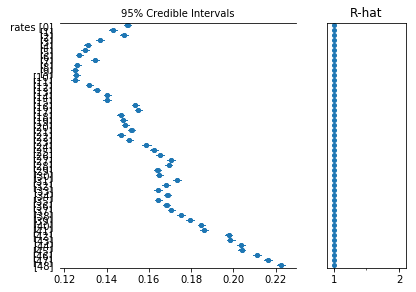

In [27]:
pm.plots.forestplot(trace, varnames=["rates"])